## _*Variational Quantum Classifier*_

The QSVM notebook demonstrates a kernel based approach. This notebook shows a variational method.

For further information please see: [https://arxiv.org/pdf/1804.11326.pdf](https://arxiv.org/pdf/1804.11326.pdf)


**This notebook shows the variational quantum classifier method.**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

import time

from qiskit.circuit.library import ZZFeatureMap, TwoLocal
from qiskit.primitives import StatevectorSampler
from qiskit.transpiler import transpile
from qiskit.transpiler.passes import Optimize1qGatesDecomposition, CommutativeCancellation
from qiskit.transpiler import PassManager

from qiskit_machine_learning.datasets import ad_hoc_data
from qiskit_algorithms.optimizers import SPSA

First we prepare the dataset, which is used for training, testing and the finally prediction.

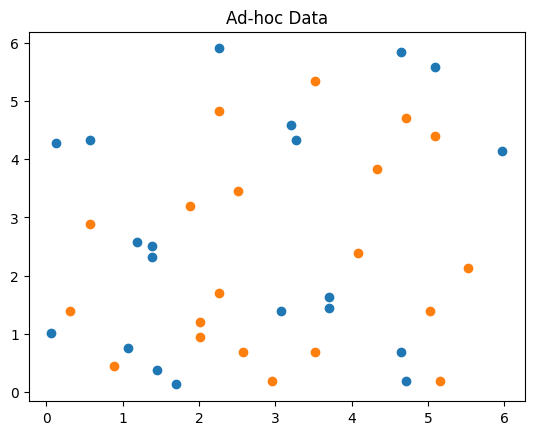

In [2]:
feature_dim = 2 # dimension of each data point
training_dataset_size = 20
testing_dataset_size = 10
random_seed = 10598
shots = 1024

train_data, train_labels, test_data, test_labels = ad_hoc_data(
    training_size=training_dataset_size,
    test_size=testing_dataset_size,
    n=feature_dim,
    gap=0.3,
    plot_data=True,
    one_hot=False
    )

The quantum circuit is made of:
- an encoder (here the ZZFeatureMap is used); x[0] and x[1] are the features of the data point
- a variational form (TwoLocal, probably the simplest there is); the parameters are those learned by the optimizer

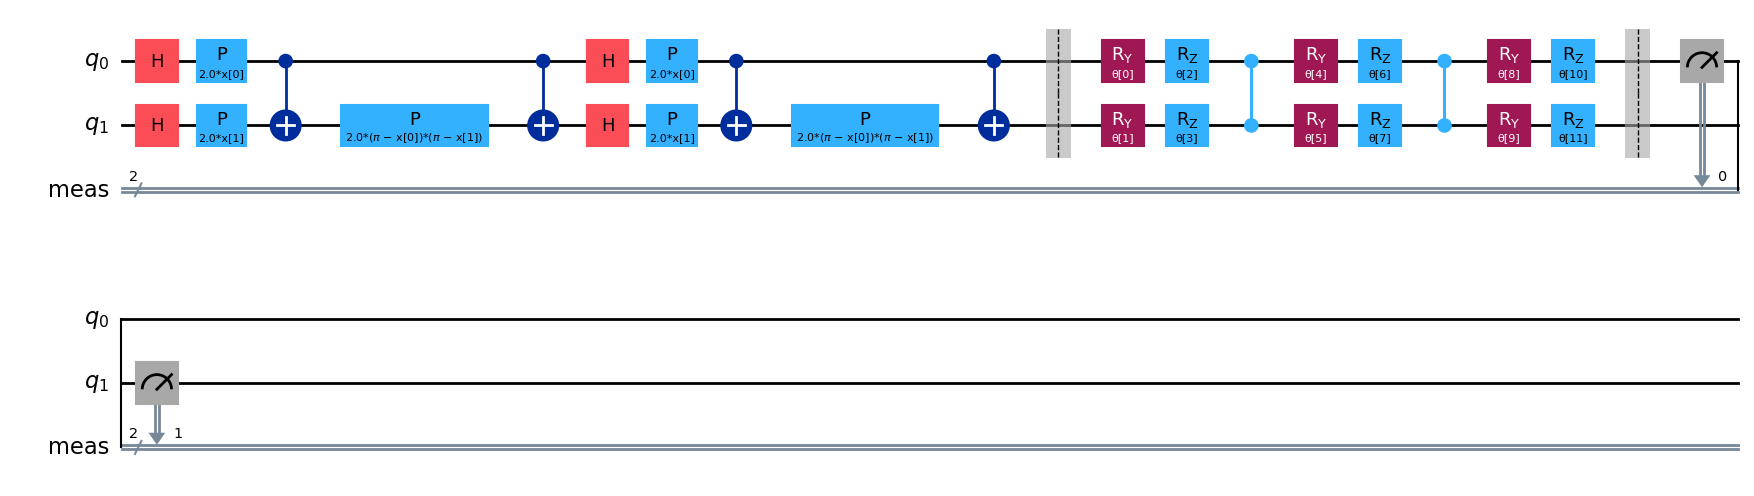

In [3]:
feature_map = ZZFeatureMap(feature_dimension=2, reps=2)
feature_map.barrier()
var_form = TwoLocal(2, ['ry', 'rz'], 'cz', reps=2)

ad_hoc_circuit = feature_map.compose(var_form)
ad_hoc_circuit.measure_all()
ad_hoc_circuit.decompose().draw(output="mpl", style="iqp")

In [ ]:
def qml_transpile(circuit, parameter_values):
    """
    Bind parameters and locally re-optimize a transpiled circuit for QML workflows.
    Args:
        circuit (QuantumCircuit): A transpiled, parameterized Qiskit circuit.
        parameter_values (dict): Dictionary mapping Parameter objects or names to values.
    Returns:
        QuantumCircuit: A fully bound, locally re-optimized circuit.
    """

    # 1. Bind parameters (use assign_parameters for compatibility)
    try:
        bound_circuit = circuit.bind_parameters(parameter_values)
    except AttributeError:
        bound_circuit = circuit.assign_parameters(parameter_values, inplace=False)

    # 2. Local re-optimization (safe for already routed circuits)
    pm = PassManager([
        Optimize1qGatesDecomposition(basis=['u3','u2','u1','rz','rx','ry','sx','x','y','z','h']),
        CommutativeCancellation(),
    ])
    optimized_circuit = pm.run(bound_circuit)

    # 3. Preserve layout if present
    if hasattr(circuit, 'layout') and circuit.layout is not None:
        optimized_circuit._layout = circuit.layout
    if hasattr(circuit, 'calibrations') and circuit.calibrations:
        optimized_circuit.calibrations = circuit.calibrations.copy()

    return optimized_circuit

In [ ]:
# Helper to zip parameters
def get_param_dict(data, variational):
    parameters = {}
    for i, p in enumerate(feature_map.ordered_parameters):
        parameters[p] = data[i]
    for i, p in enumerate(var_form.ordered_parameters):
        parameters[p] = variational[i]
    return parameters

# 1. Baseline: Transpile unbound circuit once, bind later
transpiled_unbound = transpile(ad_hoc_circuit, basis_gates=['u3', 'cx'])

def circuit_instance_baseline(data, variational):
    param_dict = get_param_dict(data, variational)
    start = time.time()
    bound = transpiled_unbound.assign_parameters(param_dict)
    elapsed = time.time() - start
    return bound, elapsed

# 2. Upper Bound: Retranspile full circuit for each parameter update
def circuit_instance_upper(data, variational):
    param_dict = get_param_dict(data, variational)
    start = time.time()
    bound = ad_hoc_circuit.assign_parameters(param_dict)
    transpiled = transpile(bound, basis_gates=['u3', 'cx'])
    elapsed = time.time() - start
    return transpiled, elapsed

def circuit_instance_qml(data, variational):
    param_dict = get_param_dict(data, variational)
    start = time.time()
    bound = qml_transpile(transpiled_unbound, param_dict)
    elapsed = time.time() - start
    return bound, elapsed

# Example: measure average time for each method over the training set
def measure_strategy(strategy_func, name):
    times = []
    for data, variational in zip(train_data, [np.random.rand(var_form.num_parameters) for _ in train_data]):
        _, elapsed = strategy_func(data, variational)
        times.append(elapsed)
    print(f"{name}: Average time per circuit = {np.mean(times)*1000:.2f} ms")

measure_strategy(circuit_instance_baseline, "Baseline (transpile once, bind later)")
measure_strategy(circuit_instance_upper, "Upper Bound (retranspile each time)")
measure_strategy(circuit_instance_qml, "QML Transpile (bind on transpiled)")

Baseline (transpile once, bind later): Average time per circuit = 0.11 ms
Upper Bound (retranspile each time): Average time per circuit = 3.06 ms
QML Transpile (bind on transpiled): Average time per circuit = 0.45 ms


In [6]:
def circuit_instance(data, variational):
    """Assigns parameter values to `AD_HOC_CIRCUIT`.
    Args:
        data (list): Data values for the feature map
        variational (list): Parameter values for `VAR_FORM`
    Returns:
        QuantumCircuit: `AD_HOC_CIRCUIT` with parameters assigned
    """
    parameters = {}
    for i, p in enumerate(feature_map.ordered_parameters):
        parameters[p] = data[i]
    for i, p in enumerate(var_form.ordered_parameters):
        parameters[p] = variational[i]
    return ad_hoc_circuit.assign_parameters(parameters)


def parity(bitstring):
    """Returns 1 if parity of `bitstring` is even, otherwise 0."""
    hamming_weight = sum(int(k) for k in list(bitstring))
    return (hamming_weight+1) % 2


def label_probability(results):
    """Converts a dict of bitstrings and their counts,
    to parities and their counts"""
    shots = sum(results.values())
    probabilities = {0: 0, 1: 0}
    for bitstring, counts in results.items():
        label = parity(bitstring)
        probabilities[label] += counts / shots
    return probabilities


def classification_probability(data, variational):
    """Classify data points using given parameters.
    Args:
        data (list): Set of data points to classify
        variational (list): Parameters for `VAR_FORM`
    Returns:
        list[dict]: Probability of circuit classifying
                    each data point as 0 or 1.
    """
    circuits = [circuit_instance(d, variational) for d in data]
    sampler = StatevectorSampler()
    results = sampler.run(circuits).result()
    classification = [
        label_probability(results[i].data.meas.get_counts()) for i, c in enumerate(circuits)]
    return classification


def cross_entropy_loss(classification, expected):
    """Calculate accuracy of predictions using cross entropy loss.
    Args:
        classification (dict): Dict where keys are possible classes,
                               and values are the probability our
                               circuit chooses that class.
        expected (int): Correct classification of the data point.

    Returns:
        float: Cross entropy loss
    """
    p = classification.get(expected)  # Prob. of correct classification
    return -np.log(p + 1e-10)


def cost_function(data, labels, variational):
    """Evaluates performance of our circuit with `variational`
    parameters on `data`.

    Args:
        data (list): List of data points to classify
        labels (list): List of correct labels for each data point
        variational (list): Parameters to use in circuit

    Returns:
        float: Cost (metric of performance)
    """
    classifications = classification_probability(data, variational)
    cost = 0
    for i, classification in enumerate(classifications):
        cost += cross_entropy_loss(classification, labels[i])
    cost /= len(data)
    return cost


def objective_function(variational):
    """Cost function of circuit parameters on training data.
    The optimizer will attempt to minimize this."""
    return cost_function(train_data, train_labels, variational)

In [7]:
class OptimizerLog:
    """Log to store optimizer's intermediate results"""
    def __init__(self):
        self.evaluations = []
        self.parameters = []
        self.costs = []
    def update(self, evaluation, parameter, cost, _stepsize, _accept):
        """Save intermediate results. Optimizer passes five values
        but we ignore the last two."""
        self.evaluations.append(evaluation)
        self.parameters.append(parameter)
        self.costs.append(cost)

# Set up the optimization

log = OptimizerLog()
optimizer = SPSA(maxiter=100, callback=log.update)

initial_point = np.zeros((var_form.num_parameters))

# # Run the optimization
# result = optimizer.minimize(objective_function, initial_point)

# opt_var = result.x
# opt_value = result.fun

# fig = plt.figure()
# plt.plot(log.evaluations, log.costs)
# plt.xlabel('Steps')
# plt.ylabel('Cost')
# plt.show()

In [8]:
def test_classifier(data, labels, variational):
    """Gets classifier's most likely predictions and accuracy of those
    predictions.

    Args:
        data (list): List of data points to classify
        labels (list): List of correct labels for each data point
        variational (list): List of parameter values for classifier

    Returns:
        float: Average accuracy of classifier over `data`
        list: Classifier's label predictions for each data point
    """
    probability = classification_probability(data, variational)
    predictions = [0 if p[0] >= p[1] else 1 for p in probability]
    accuracy = 0

    for i, prediction in enumerate(predictions):
        if prediction == labels[i]:
            accuracy += 1
    accuracy /= len(labels)
    return accuracy, predictions

# accuracy, predictions = test_classifier(test_data, test_labels, opt_var)
# accuracy

In [9]:
# plt.figure(figsize=(9, 6))

# for feature, label in zip(train_data, train_labels):
#     COLOR = 'C0' if label == 0 else 'C1'
#     plt.scatter(feature[0], feature[1],
#                 marker='o', s=100, color=COLOR)

# for feature, label, pred in zip(test_data, test_labels, predictions):
#     COLOR = 'C0' if pred == 0 else 'C1'
#     plt.scatter(feature[0], feature[1],
#                 marker='s', s=100, color=COLOR)
#     if label != pred:  # mark wrongly classified
#         plt.scatter(feature[0], feature[1], marker='o', s=500,
#                     linewidths=2.5, facecolor='none', edgecolor='C3')

# legend_elements = [
#     Line2D([0], [0], marker='o', c='w', mfc='C1', label='A', ms=10),
#     Line2D([0], [0], marker='o', c='w', mfc='C0', label='B', ms=10),
#     Line2D([0], [0], marker='s', c='w', mfc='C1', label='predict A',
#            ms=10),
#     Line2D([0], [0], marker='s', c='w', mfc='C0', label='predict B',
#            ms=10),
#     Line2D([0], [0], marker='o', c='w', mfc='none', mec='C3',
#            label='wrongly classified', mew=2, ms=15)
# ]

# plt.legend(handles=legend_elements, bbox_to_anchor=(1, 1),
#            loc='upper left')

# plt.title('Training & Test Data')
# plt.xlabel('x')
# plt.ylabel('y')
# plt.show()

In [10]:
# ! pip freeze | grep qiskit

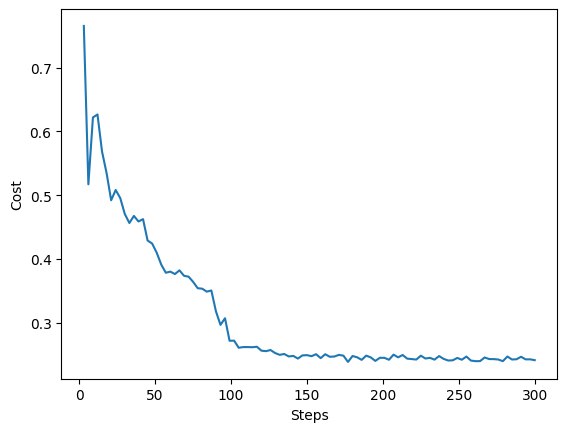

QML Transpile: 14060 calls, total 6.161s, avg 0.44 ms/call, avg depth 14.00


In [11]:
#  --- GLOBAL TIMING AND DEPTH VARIABLES ---
baseline_total_time = 0.0
baseline_calls = 0
baseline_total_depth = 0

upper_total_time = 0.0
upper_calls = 0
upper_total_depth = 0

qml_total_time = 0.0
qml_calls = 0
qml_total_depth = 0

# --- CIRCUIT INSTANCE FUNCTIONS WITH TIMING AND DEPTH ---

def circuit_instance_baseline(data, variational):
    global baseline_total_time, baseline_calls, baseline_total_depth
    param_dict = get_param_dict(data, variational)
    start = time.time()
    bound = transpiled_unbound.assign_parameters(param_dict)
    elapsed = time.time() - start
    baseline_total_time += elapsed
    baseline_calls += 1
    baseline_total_depth += bound.depth()
    return bound, elapsed

def circuit_instance_upper(data, variational):
    global upper_total_time, upper_calls, upper_total_depth
    param_dict = get_param_dict(data, variational)
    start = time.time()
    bound = ad_hoc_circuit.assign_parameters(param_dict)
    transpiled = transpile(bound)
    elapsed = time.time() - start
    upper_total_time += elapsed
    upper_calls += 1
    upper_total_depth += transpiled.depth()
    return transpiled, elapsed

def circuit_instance_qml(data, variational):
    global qml_total_time, qml_calls, qml_total_depth
    param_dict = get_param_dict(data, variational)
    start = time.time()
    bound = qml_transpile(transpiled_unbound, param_dict)
    elapsed = time.time() - start
    qml_total_time += elapsed
    qml_calls += 1
    qml_total_depth += bound.depth()
    return bound, elapsed

# --- AFTER OPTIMIZATION, PRINT TIMING AND DEPTH STATS ---
def print_strategy_timings():
    if baseline_calls > 0:
        print(f"Baseline: {baseline_calls} calls, total {baseline_total_time:.3f}s, avg {baseline_total_time/baseline_calls*1000:.2f} ms/call, avg depth {baseline_total_depth/baseline_calls:.2f}")
    if upper_calls > 0:
        print(f"Upper Bound: {upper_calls} calls, total {upper_total_time:.3f}s, avg {upper_total_time/upper_calls*1000:.2f} ms/call, avg depth {upper_total_depth/upper_calls:.2f}")
    if qml_calls > 0:
        print(f"QML Transpile: {qml_calls} calls, total {qml_total_time:.3f}s, avg {qml_total_time/qml_calls*1000:.2f} ms/call, avg depth {qml_total_depth/qml_calls:.2f}")

# --- STRATEGY SELECTOR ---
# Choose one: circuit_instance_baseline, circuit_instance_upper, circuit_instance_qml
# CIRCUIT_INSTANCE_FUNC = circuit_instance_baseline
# CIRCUIT_INSTANCE_FUNC = circuit_instance_upper
CIRCUIT_INSTANCE_FUNC = circuit_instance_qml

# --- UPDATED QML WORKFLOW FUNCTIONS ---

def classification_probability(data, variational, circuit_instance_func=CIRCUIT_INSTANCE_FUNC):
    """Classify data points using given parameters and selected circuit instance function."""
    circuits = [circuit_instance_func(d, variational)[0] for d in data]
    sampler = StatevectorSampler()
    results = sampler.run(circuits).result()
    classification = [
        label_probability(results[i].data.meas.get_counts()) for i, c in enumerate(circuits)]
    return classification

def cost_function(data, labels, variational, circuit_instance_func=CIRCUIT_INSTANCE_FUNC):
    """Evaluates performance of our circuit with `variational` parameters on `data`."""
    classifications = classification_probability(data, variational, circuit_instance_func)
    cost = 0
    for i, classification in enumerate(classifications):
        cost += cross_entropy_loss(classification, labels[i])
    cost /= len(data)
    return cost

def objective_function(variational, circuit_instance_func=CIRCUIT_INSTANCE_FUNC):
    """Cost function of circuit parameters on training data."""
    return cost_function(train_data, train_labels, variational, circuit_instance_func)

# --- OPTIMIZATION LOOP (unchanged, uses selected strategy) ---
log = OptimizerLog()
optimizer = SPSA(maxiter=100, callback=log.update)
initial_point = np.zeros((var_form.num_parameters))

# Run the optimization with the selected transpilation strategy
result = optimizer.minimize(lambda v: objective_function(v, CIRCUIT_INSTANCE_FUNC), initial_point)

opt_var = result.x
opt_value = result.fun

fig = plt.figure()
plt.plot(log.evaluations, log.costs)
plt.xlabel('Steps')
plt.ylabel('Cost')
plt.show()

# --- TESTING (also uses selected strategy) ---
def test_classifier(data, labels, variational, circuit_instance_func=CIRCUIT_INSTANCE_FUNC):
    """Gets classifier's most likely predictions and accuracy of those predictions."""
    probability = classification_probability(data, variational, circuit_instance_func)
    predictions = [0 if p[0] >= p[1] else 1 for p in probability]
    accuracy = sum(1 for i, prediction in enumerate(predictions) if prediction == labels[i]) / len(labels)
    return accuracy, predictions

accuracy, predictions = test_classifier(test_data, test_labels, opt_var, CIRCUIT_INSTANCE_FUNC)
accuracy

print_strategy_timings()